<a href="https://colab.research.google.com/github/dbtmddn41/deep_learning/blob/main/kaggle/tpu_plant_pathology.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# This mounts your Google Drive to the Colab VM.
from google.colab import drive, auth
auth.authenticate_user()
drive.mount('/content/drive')

# TODO: Enter the foldername in your Drive where you have saved the unzipped
# assignment folder, e.g. 'cs231n/assignments/assignment1/'
FOLDERNAME = '딥러닝/kaggle/plant\ pathology'

# Now that we've mounted your Drive, this ensures that
# the Python interpreter of the Colab VM can load
# python files from within it.
import sys
sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))

%cd /content/drive/My\ Drive/$FOLDERNAME/

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/딥러닝/kaggle/plant pathology


In [ ]:
import tensorflow as tf
import numpy as np
import os

try:
  device_name = os.environ['COLAB_TPU_ADDR']
  TPU_ADDRESS = 'grpc://' + device_name
  print('Found TPU at: {}'.format(TPU_ADDRESS))

except KeyError:
  print('TPU not found')

Found TPU at: grpc://10.77.154.138:8470


In [ ]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras import layers
import cv2

# 데이터 둘러보기

In [ ]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
submission = pd.read_csv('sample_submission.csv')

In [ ]:
healthy = train.loc[train['healthy']==1]
multi_diseases = train.loc[train['multiple_diseases']==1]
rust = train.loc[train['rust']==1]
scab = train.loc[train['scab']==1]
label = sorted(list(train))
label.remove('image_id')

In [ ]:
from sklearn.model_selection import train_test_split

train_data, val_data = train_test_split(train, test_size=0.05, stratify=train[label], random_state=42)
num_train = len(train_data)
num_val = len(val_data)
print(num_train, num_val)

1729 92


In [ ]:
import os, shutil, pathlib

# if 'plant_train' in os.listdir():
#     shutil.rmtree('plant_train/')

origin_dir = pathlib.Path("images")
new_base_dir = pathlib.Path("plant_train")
# def make_subset(subset_name, df, labels):
#     for i, category in enumerate(labels):
#         dir = new_base_dir / subset_name / category
#         os.makedirs(dir)
#         fnames = df[df[category]==1]['image_id']
#         for fname in fnames:
#             shutil.copyfile(src=origin_dir/(fname+'.jpg'), dst=dir/(fname+'.jpg'))

# make_subset("train", train_data, label)
# make_subset("validation", val_data, label)

# TFRecord

## 데이터 만들기

In [ ]:
def image_feature(value):
    """Returns a bytes_list from a string / byte."""
    return tf.train.Feature(
        bytes_list=tf.train.BytesList(value=[tf.io.encode_jpeg(value).numpy()])
    )


def bytes_feature(value):
    """Returns a bytes_list from a string / byte."""
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))


def float_feature(value):
    """Returns a float_list from a float / double."""
    return tf.train.Feature(float_list=tf.train.FloatList(value=[value]))


def int64_feature(value):
    """Returns an int64_list from a bool / enum / int / uint."""
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))


def float_feature_list(value):
    """Returns a list of float_list from a float / double."""
    return tf.train.Feature(float_list=tf.train.FloatList(value=value))

def create_example(image, example):
    feature = {
        "image": image_feature(image),
        "target": bytes_feature(np.array(example.drop(['image_id']), dtype=np.int32).tobytes()),
        "image_id":  bytes_feature(example["image_id"].encode())
    }
    return tf.train.Example(features=tf.train.Features(feature=feature))

In [ ]:
from tqdm import tqdm

def write_tfrecord(df, input_path ,output_path):
    with tf.io.TFRecordWriter(output_path) as writer:
        for index, row in tqdm(df.iterrows(), total=df.shape[0]):
            img_path = os.path.join(input_path, row['image_id'] + '.jpg')
            image = tf.io.decode_jpeg(tf.io.read_file(img_path))
            tf_example = create_example(image, example=row)
            writer.write(tf_example.SerializeToString())

train_filename = "plant_pathology_train.tfrec"
validation_filename = "plant_pathology_validation.tfrec"
test_filename = "plant_pathology_test.tfrec"

write_tfrecord(train_data, 'images', train_filename)
write_tfrecord(val_data, 'images', validation_filename)
write_tfrecord(submission, 'images', test_filename)


100%|██████████| 1821/1821 [15:08<00:00,  2.01it/s]


이후 내 google cloud storage에 tfrecord 파일을 올린다.

## TFRecord를 tf.data.Dataset으로 변환

In [ ]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect()
    print("Device:", tpu.master())
    strategy = tf.distribute.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print("Number of replicas:", strategy.num_replicas_in_sync)

Device: grpc://10.77.154.138:8470
Number of replicas: 8


In [ ]:
GCS_PATH = "gs://plant_pathology_800"

train_filenames = tf.io.gfile.glob(GCS_PATH + "/*train.tfrec")
validation_filenames = tf.io.gfile.glob(GCS_PATH + "/*validation.tfrec")
test_filenames = tf.io.gfile.glob(GCS_PATH + "/*test.tfrec")

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

BATCH_SIZE = 8 * strategy.num_replicas_in_sync
img_size=(800,800)

def decode_image(image):
    image = tf.io.decode_jpeg(image, channels=3)
    image = tf.cast(image, tf.float32)
    image = tf.image.resize(image, size=img_size)
    return image

def parse_tfrecord_fn(serialized_string):
    feature_description = {
        "image": tf.io.FixedLenFeature([], tf.string),
        "target": tf.io.FixedLenFeature([], tf.string),
        "image_id": tf.io.FixedLenFeature([], tf.string)
    }
    example = tf.io.parse_single_example(serialized_string, feature_description)
    image = decode_image(example["image"])
    target = tf.io.decode_raw(example["target"], tf.int32)
    return image, target

In [ ]:
def load_dataset(filenames):
    ignore_order = tf.data.Options()
    ignore_order.experimental_deterministic = False  # disable order, increase speed
    dataset = tf.data.TFRecordDataset(
        filenames
    )  # automatically interleaves reads from multiple files
    dataset = dataset.with_options(
        ignore_order
    )  # uses data as soon as it streams in, rather than in its original order
    dataset = dataset.map(
        parse_tfrecord_fn, num_parallel_calls=AUTOTUNE
    )
    return dataset


def get_dataset(filenames, data_augment_fn=None):
    dataset = load_dataset(filenames)
    dataset = dataset.shuffle(2048)
    dataset = dataset.repeat()
    dataset = dataset.batch(BATCH_SIZE)
    if data_augment_fn:
        dataset = dataset.map(data_augment_fn, num_parallel_calls=AUTOTUNE)
    dataset = dataset.prefetch(buffer_size=AUTOTUNE)
    return dataset


data_augment = keras.Sequential([
    layers.RandomBrightness(0.2, value_range=(0, 255), seed=42),
    layers.RandomContrast(0.2, seed=43),
    layers.RandomFlip(mode='horizontal_and_vertical', seed=44),
    layers.RandomRotation(0.1, seed=45),
    layers.RandomZoom(0.2, seed=46),
    layers.RandomTranslation(0.1, 0.1, seed=47)
    ])

def data_augment_fn(img, label):
    return data_augment(img), label

train_dataset = get_dataset(train_filenames, data_augment_fn=data_augment_fn)
validation_dataset = get_dataset(validation_filenames)
test_dataset = get_dataset(test_filenames)

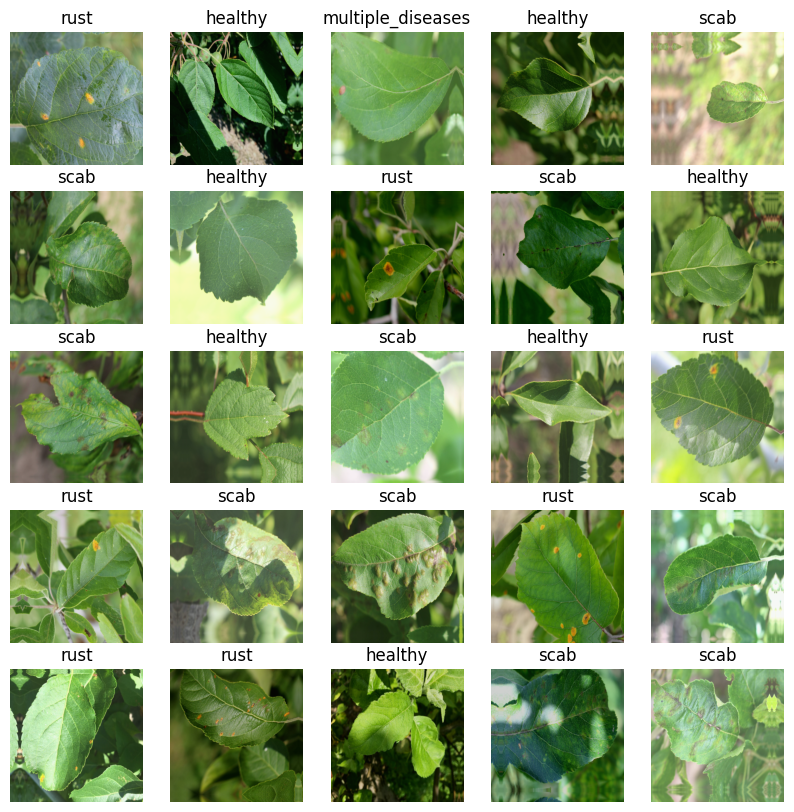

In [ ]:
image_batch, label_batch = next(iter(train_dataset))

label = list(train)
label.remove('image_id')
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10, 10))
    for n in range(25):
        ax = plt.subplot(5, 5, n + 1)
        plt.imshow(image_batch[n] / 255.0)
        cls = np.argmax(label_batch[n])
        plt.title(label[cls])
        plt.axis("off")
show_batch(image_batch.numpy(), label_batch)

# 모델 만들기

## unfreeze

In [ ]:
def get_model(epochs):

    eff_cnn = keras.applications.EfficientNetV2M(
        include_top=False,
        weights="imagenet",
        input_shape=(*img_size, 3),
        pooling='avg'
    )

    eff_cnn.trainable = True
    # for layer in eff_cnn.layers[-4:]:
    #     layer.trainable = True

    inputs = keras.Input(shape=(*img_size, 3))
    x = eff_cnn(inputs)
    x = layers.Dropout(0.4)(x)
    x = layers.Dense(800, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(4, activation='softmax')(x)

    model = keras.Model(inputs, outputs)
    lr_schedule = keras.optimizers.schedules.CosineDecay(initial_learning_rate=1e-3, decay_steps=len(train_data) / BATCH_SIZE *epochs)

    optimizer = keras.optimizers.experimental.AdamW(learning_rate=lr_schedule, weight_decay=0.0001)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'], steps_per_execution=8)

    return model

In [ ]:
callbacks = [keras.callbacks.ModelCheckpoint(filepath='best_model_tpu_do04.keras', save_best_only=True, monitor='val_loss'),
             keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)]
epochs = 200

with strategy.scope():
    model = get_model(epochs)


214201816/214201816 [==============================] - 1s 0us/step


In [ ]:
import math

steps_per_epoch = math.ceil(len(train_data) / BATCH_SIZE) * 8
validation_steps = math.ceil(len(val_data) / BATCH_SIZE)

history = model.fit(train_dataset, epochs=epochs, steps_per_epoch=steps_per_epoch,
                    callbacks=callbacks, validation_data=validation_dataset, validation_steps=validation_steps)


Epoch 1/200
224/224 [==============================] - 240s 1s/step - loss: 0.2907 - accuracy: 0.9087 - val_loss: 0.2902 - val_accuracy: 0.8906
Epoch 2/200
224/224 [==============================] - 192s 858ms/step - loss: 0.1588 - accuracy: 0.9494 - val_loss: 0.0854 - val_accuracy: 0.9609
Epoch 3/200
224/224 [==============================] - 176s 787ms/step - loss: 0.1073 - accuracy: 0.9638 - val_loss: 0.2174 - val_accuracy: 0.9375
Epoch 4/200
224/224 [==============================] - 176s 785ms/step - loss: 0.0856 - accuracy: 0.9706 - val_loss: 0.1635 - val_accuracy: 0.9375
Epoch 5/200
224/224 [==============================] - 176s 784ms/step - loss: 0.0694 - accuracy: 0.9783 - val_loss: 0.2344 - val_accuracy: 0.9375
Epoch 6/200
224/224 [==============================] - 176s 785ms/step - loss: 0.0558 - accuracy: 0.9809 - val_loss: 0.0903 - val_accuracy: 0.9688
Epoch 7/200
224/224 [==============================] - 176s 785ms/step - loss: 0.0504 - accuracy: 0.9840 - val_loss: 0.37

KeyboardInterrupt: ignored

# 정답 제출

In [ ]:
with strategy.scope():
    best_model = keras.models.load_model('best_model_tpu_do04.keras')
best_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 800, 800, 3)]     0         
                                                                 
 efficientnetv2-m (Functiona  (None, 1280)             53150388  
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 800)               1024800   
                                                                 
 dropout_1 (Dropout)         (None, 800)               0         
                                                                 
 dense_1 (Dense)             (None, 4)                 3204      
                                                             

In [ ]:
!mkdir -p ~/.kaggle
!cp ./kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle competitions download -c plant-pathology-2020-fgvc7 --force

!unzip -qq -o plant-pathology-2020-fgvc7.zip

100% 778M/779M [00:05<00:00, 206MB/s]
100% 779M/779M [00:05<00:00, 149MB/s]


In [ ]:
from sklearn.metrics import roc_auc_score
import cv2
from tqdm import tqdm

img_size=(800,800)
validation_imgs = []
resize_layer = layers.Resizing(*img_size)
for img_name in tqdm(val_data['image_id']):
    img_path = '/content/images/' + img_name + '.jpg'
    image = cv2.imread(img_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = resize_layer(image)
    validation_imgs.append(image)

pred = best_model.predict(np.array(validation_imgs))
print(roc_auc_score(val_data[label], pred))

100%|██████████| 92/92 [00:03<00:00, 29.08it/s]


3/3 [==============================] - 40s 7s/step
1.0


In [ ]:
resize_layer = layers.Resizing(*img_size)
# test_imgs = []
# for img_name in tqdm(submission['image_id']):
#     img_path = '/content/images/' + img_name + '.jpg'
#     image = cv2.imread(img_path)
#     image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
#     image = resize_layer(image)
#     test_imgs.append(image)

preds = np.zeros((len(submission), 4))
for i, img_name in enumerate(tqdm(submission['image_id'])):
    if i % 100 == 0:
        if i != 0:
            preds[i-100:i] = best_model.predict(np.array(test_imgs))
        test_imgs = []

    img_path = '/content/images/' + img_name + '.jpg'
    image = cv2.imread(img_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = resize_layer(image)
    test_imgs.append(image)

preds[len(submission)-len(test_imgs):] = best_model.predict(np.array(test_imgs))


  5%|▌         | 99/1821 [00:03<00:55, 31.18it/s]

4/4 [==============================] - 10s 3s/step


 11%|█         | 199/1821 [00:18<00:51, 31.31it/s]

4/4 [==============================] - 8s 2s/step


 16%|█▋        | 300/1821 [00:31<00:48, 31.11it/s]

4/4 [==============================] - 8s 2s/step


 22%|██▏       | 400/1821 [00:44<00:45, 31.20it/s]

4/4 [==============================] - 8s 2s/step


 27%|██▋       | 500/1821 [00:57<00:41, 31.68it/s]

4/4 [==============================] - 8s 2s/step


 33%|███▎      | 600/1821 [01:11<00:39, 30.76it/s]

4/4 [==============================] - 8s 2s/step


 38%|███▊      | 697/1821 [01:26<00:36, 30.81it/s]

4/4 [==============================] - 8s 2s/step


 44%|████▍     | 800/1821 [01:40<01:02, 16.34it/s]

4/4 [==============================] - 8s 2s/step


 49%|████▉     | 897/1821 [01:53<00:29, 31.52it/s]

4/4 [==============================] - 8s 2s/step


 55%|█████▍    | 998/1821 [02:07<00:26, 30.65it/s]

4/4 [==============================] - 8s 2s/step


 60%|██████    | 1100/1821 [02:20<00:22, 31.62it/s]

4/4 [==============================] - 8s 2s/step


 66%|██████▌   | 1200/1821 [02:33<00:19, 31.09it/s]

4/4 [==============================] - 8s 2s/step


 71%|███████▏  | 1300/1821 [02:45<00:16, 31.67it/s]

4/4 [==============================] - 8s 2s/step


 77%|███████▋  | 1399/1821 [02:58<00:13, 31.46it/s]

4/4 [==============================] - 8s 2s/step


 82%|████████▏ | 1499/1821 [03:11<00:10, 30.60it/s]

4/4 [==============================] - 8s 2s/step


 88%|████████▊ | 1599/1821 [03:24<00:07, 31.28it/s]

4/4 [==============================] - 8s 2s/step


 93%|█████████▎| 1699/1821 [03:37<00:03, 31.28it/s]

4/4 [==============================] - 8s 2s/step


 99%|█████████▉| 1799/1821 [03:50<00:00, 31.53it/s]

4/4 [==============================] - 8s 2s/step


100%|██████████| 1821/1821 [04:01<00:00,  7.55it/s]


1/1 [==============================] - 1s 733ms/step


In [ ]:
submission[label] = preds
submission.head()

,image_id,healthy,multiple_diseases,rust,scab
0,Test_0,1.326653e-05,5.879684e-05,9.999276e-01,2.918106e-07
1,Test_1,3.732376e-07,8.969043e-07,9.999987e-01,2.301118e-08
2,Test_2,4.299719e-11,2.295734e-08,5.958775e-14,1.000000e+00
3,Test_3,1.000000e+00,9.955877e-10,5.164029e-09,2.238246e-08
4,Test_4,1.027896e-10,4.479250e-09,1.000000e+00,9.109668e-13


In [ ]:
submission.to_csv('/content/submission.csv', index=False)

## TTA

In [ ]:
data_augment = keras.Sequential([
    layers.RandomBrightness(0.2, value_range=(0, 255), seed=42),
    layers.RandomContrast(0.2, seed=43),
    layers.RandomFlip(mode='horizontal_and_vertical', seed=44),
    layers.RandomRotation(0.1, seed=45),
    layers.RandomZoom(0.2, seed=46),
    layers.RandomTranslation(0.1, 0.1, seed=47)
])
img_size=(800,800)
resize_layer = layers.Resizing(*img_size)

In [ ]:
from tqdm import tqdm
from sklearn.metrics import roc_auc_score
import cv2

num_augment = 8

resize_layer = layers.Resizing(*img_size)
pred_avg = np.zeros((len(val_data), 4))

for i, img_name in enumerate(tqdm(val_data['image_id'])):
    if i % 20 == 0:
        if i != 0:
            pred = best_model.predict(np.array(val_imgs))
            pred_avg[i-20:i] = pred.reshape(len(pred)//num_augment, num_augment, -1).mean(axis=1)
        val_imgs = []
    img_path = '/content/images/' + img_name + '.jpg'
    image = cv2.imread(img_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = resize_layer(image)
    for j in range(num_augment):
        aug_image = data_augment(image)
        val_imgs.append(aug_image)

pred = best_model.predict(np.array(val_imgs))
pred_avg[len(val_data)-len(pred)//num_augment:] = pred.reshape(len(pred)//num_augment, num_augment, -1).mean(axis=1)

print(roc_auc_score(val_data[label], pred_avg))

 22%|██▏       | 20/92 [00:14<00:51,  1.40it/s]

5/5 [==============================] - 22s 4s/step


 43%|████▎     | 40/92 [01:06<00:38,  1.36it/s]

5/5 [==============================] - 1s 149ms/step


 65%|██████▌   | 60/92 [01:37<00:22,  1.40it/s]

5/5 [==============================] - 1s 157ms/step


 87%|████████▋ | 80/92 [02:08<00:08,  1.40it/s]

5/5 [==============================] - 1s 169ms/step


100%|██████████| 92/92 [02:33<00:00,  1.67s/it]


3/3 [==============================] - 1s 212ms/step
1.0


In [ ]:
num_augment = 8

resize_layer = layers.Resizing(*img_size)

test_imgs = []
pred_avg = np.zeros((len(submission), 4))

for i, img_name in enumerate(tqdm(submission['image_id'])):
    if i % 20 == 0:
        if i != 0:
            pred = best_model.predict(np.array(test_imgs))
            pred_avg[i-20:i] = pred.reshape(len(pred)//num_augment, num_augment, -1).mean(axis=1)
        test_imgs = []
    img_path = '/content/images/' + img_name + '.jpg'
    image = cv2.imread(img_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = resize_layer(image)
    for j in range(num_augment):
        aug_image = data_augment(image)
        test_imgs.append(aug_image)

pred = best_model.predict(np.array(test_imgs))
pred_avg[len(submission)-len(pred)//num_augment:] = pred.reshape(len(pred)//num_augment, num_augment, -1).mean(axis=1)

  1%|          | 20/1821 [00:14<21:29,  1.40it/s]

5/5 [==============================] - 1s 149ms/step


  2%|▏         | 40/1821 [00:45<21:05,  1.41it/s]

5/5 [==============================] - 1s 147ms/step


  3%|▎         | 60/1821 [01:16<21:09,  1.39it/s]

5/5 [==============================] - 1s 149ms/step


  4%|▍         | 80/1821 [01:47<21:00,  1.38it/s]

5/5 [==============================] - 1s 151ms/step


  5%|▌         | 100/1821 [02:18<20:36,  1.39it/s]

5/5 [==============================] - 1s 159ms/step


  7%|▋         | 120/1821 [02:49<21:03,  1.35it/s]

5/5 [==============================] - 1s 157ms/step


  8%|▊         | 140/1821 [03:21<21:05,  1.33it/s]

5/5 [==============================] - 1s 150ms/step


  9%|▉         | 160/1821 [03:52<20:16,  1.37it/s]

5/5 [==============================] - 1s 149ms/step


 10%|▉         | 180/1821 [04:24<20:09,  1.36it/s]

5/5 [==============================] - 1s 149ms/step


 11%|█         | 200/1821 [04:55<19:47,  1.37it/s]

5/5 [==============================] - 1s 157ms/step


 12%|█▏        | 220/1821 [05:26<19:50,  1.34it/s]

5/5 [==============================] - 1s 151ms/step


 13%|█▎        | 240/1821 [05:58<19:43,  1.34it/s]

5/5 [==============================] - 1s 148ms/step


 14%|█▍        | 260/1821 [06:30<19:26,  1.34it/s]

5/5 [==============================] - 1s 150ms/step


 15%|█▌        | 280/1821 [07:01<18:32,  1.38it/s]

5/5 [==============================] - 1s 146ms/step


 16%|█▋        | 300/1821 [07:32<18:40,  1.36it/s]

5/5 [==============================] - 1s 158ms/step


 18%|█▊        | 320/1821 [08:04<18:40,  1.34it/s]

5/5 [==============================] - 1s 153ms/step


 19%|█▊        | 340/1821 [08:36<19:31,  1.26it/s]

5/5 [==============================] - 1s 157ms/step


 20%|█▉        | 360/1821 [09:09<18:31,  1.31it/s]

5/5 [==============================] - 1s 148ms/step


 21%|██        | 380/1821 [09:42<18:25,  1.30it/s]

5/5 [==============================] - 1s 149ms/step


 22%|██▏       | 400/1821 [10:14<18:09,  1.30it/s]

5/5 [==============================] - 1s 151ms/step


 23%|██▎       | 420/1821 [10:47<17:56,  1.30it/s]

5/5 [==============================] - 1s 152ms/step


 24%|██▍       | 440/1821 [11:19<17:29,  1.32it/s]

5/5 [==============================] - 1s 159ms/step


 25%|██▌       | 460/1821 [11:52<17:43,  1.28it/s]

5/5 [==============================] - 2s 151ms/step


 26%|██▋       | 480/1821 [12:25<17:27,  1.28it/s]

5/5 [==============================] - 1s 160ms/step


 27%|██▋       | 500/1821 [12:58<17:12,  1.28it/s]

5/5 [==============================] - 1s 149ms/step


 29%|██▊       | 520/1821 [13:30<16:27,  1.32it/s]

5/5 [==============================] - 1s 160ms/step


 30%|██▉       | 540/1821 [14:03<16:57,  1.26it/s]

5/5 [==============================] - 1s 150ms/step


 31%|███       | 560/1821 [14:36<16:13,  1.30it/s]

5/5 [==============================] - 1s 163ms/step


 32%|███▏      | 580/1821 [15:08<15:46,  1.31it/s]

5/5 [==============================] - 1s 159ms/step


 33%|███▎      | 600/1821 [15:41<15:45,  1.29it/s]

5/5 [==============================] - 1s 148ms/step


 34%|███▍      | 620/1821 [16:13<15:38,  1.28it/s]

5/5 [==============================] - 1s 151ms/step


 35%|███▌      | 640/1821 [16:45<15:03,  1.31it/s]

5/5 [==============================] - 1s 159ms/step


 36%|███▌      | 660/1821 [17:18<14:44,  1.31it/s]

5/5 [==============================] - 1s 150ms/step


 37%|███▋      | 680/1821 [17:50<14:46,  1.29it/s]

5/5 [==============================] - 1s 152ms/step


 38%|███▊      | 700/1821 [18:22<14:42,  1.27it/s]

5/5 [==============================] - 1s 148ms/step


 40%|███▉      | 720/1821 [18:55<14:16,  1.29it/s]

5/5 [==============================] - 1s 151ms/step


 41%|████      | 740/1821 [19:28<14:00,  1.29it/s]

5/5 [==============================] - 1s 151ms/step


 42%|████▏     | 760/1821 [20:00<13:49,  1.28it/s]

5/5 [==============================] - 1s 152ms/step


 43%|████▎     | 780/1821 [20:33<13:25,  1.29it/s]

5/5 [==============================] - 1s 151ms/step


 44%|████▍     | 800/1821 [21:05<13:05,  1.30it/s]

5/5 [==============================] - 1s 150ms/step


 45%|████▌     | 820/1821 [21:37<13:20,  1.25it/s]

5/5 [==============================] - 1s 152ms/step


 46%|████▌     | 840/1821 [22:09<12:24,  1.32it/s]

5/5 [==============================] - 1s 160ms/step


 47%|████▋     | 860/1821 [22:41<12:54,  1.24it/s]

5/5 [==============================] - 1s 158ms/step


 48%|████▊     | 880/1821 [23:14<12:41,  1.24it/s]

5/5 [==============================] - 1s 164ms/step


 49%|████▉     | 900/1821 [23:46<11:42,  1.31it/s]

5/5 [==============================] - 1s 148ms/step


 51%|█████     | 920/1821 [24:18<11:34,  1.30it/s]

5/5 [==============================] - 1s 149ms/step


 52%|█████▏    | 940/1821 [24:50<11:26,  1.28it/s]

5/5 [==============================] - 1s 150ms/step


 53%|█████▎    | 960/1821 [25:22<11:28,  1.25it/s]

5/5 [==============================] - 1s 149ms/step


 54%|█████▍    | 980/1821 [25:55<10:52,  1.29it/s]

5/5 [==============================] - 1s 159ms/step


 55%|█████▍    | 1000/1821 [26:27<10:49,  1.26it/s]

5/5 [==============================] - 1s 148ms/step


 56%|█████▌    | 1020/1821 [26:59<10:26,  1.28it/s]

5/5 [==============================] - 1s 153ms/step


 57%|█████▋    | 1040/1821 [27:31<10:28,  1.24it/s]

5/5 [==============================] - 1s 164ms/step


 58%|█████▊    | 1060/1821 [28:04<10:07,  1.25it/s]

5/5 [==============================] - 2s 159ms/step


 59%|█████▉    | 1080/1821 [28:37<09:53,  1.25it/s]

5/5 [==============================] - 1s 155ms/step


 60%|██████    | 1100/1821 [29:09<09:42,  1.24it/s]

5/5 [==============================] - 1s 161ms/step


 62%|██████▏   | 1120/1821 [29:41<09:18,  1.26it/s]

5/5 [==============================] - 1s 151ms/step


 63%|██████▎   | 1140/1821 [30:14<09:00,  1.26it/s]

5/5 [==============================] - 1s 162ms/step


 64%|██████▎   | 1160/1821 [30:46<08:55,  1.24it/s]

5/5 [==============================] - 1s 153ms/step


 65%|██████▍   | 1180/1821 [31:19<08:42,  1.23it/s]

5/5 [==============================] - 1s 150ms/step


 66%|██████▌   | 1200/1821 [31:51<08:26,  1.23it/s]

5/5 [==============================] - 1s 161ms/step


 67%|██████▋   | 1220/1821 [32:24<08:00,  1.25it/s]

5/5 [==============================] - 1s 152ms/step


 68%|██████▊   | 1240/1821 [32:56<07:48,  1.24it/s]

5/5 [==============================] - 1s 159ms/step


 69%|██████▉   | 1260/1821 [33:28<07:21,  1.27it/s]

5/5 [==============================] - 1s 151ms/step


 70%|███████   | 1280/1821 [34:00<06:52,  1.31it/s]

5/5 [==============================] - 1s 161ms/step


 71%|███████▏  | 1300/1821 [34:32<06:43,  1.29it/s]

5/5 [==============================] - 1s 148ms/step


 72%|███████▏  | 1320/1821 [35:03<06:36,  1.26it/s]

5/5 [==============================] - 1s 157ms/step


 74%|███████▎  | 1340/1821 [35:35<06:10,  1.30it/s]

5/5 [==============================] - 1s 153ms/step


 75%|███████▍  | 1360/1821 [36:06<05:54,  1.30it/s]

5/5 [==============================] - 1s 148ms/step


 76%|███████▌  | 1380/1821 [36:38<05:37,  1.31it/s]

5/5 [==============================] - 1s 146ms/step


 77%|███████▋  | 1400/1821 [37:09<05:33,  1.26it/s]

5/5 [==============================] - 1s 150ms/step


 78%|███████▊  | 1420/1821 [37:41<05:12,  1.28it/s]

5/5 [==============================] - 1s 152ms/step


 79%|███████▉  | 1440/1821 [38:14<04:54,  1.29it/s]

5/5 [==============================] - 1s 158ms/step


 80%|████████  | 1460/1821 [38:45<04:56,  1.22it/s]

5/5 [==============================] - 1s 150ms/step


 81%|████████▏ | 1480/1821 [39:17<04:26,  1.28it/s]

5/5 [==============================] - 1s 156ms/step


 82%|████████▏ | 1500/1821 [39:49<04:12,  1.27it/s]

5/5 [==============================] - 1s 148ms/step


 83%|████████▎ | 1520/1821 [40:21<03:51,  1.30it/s]

5/5 [==============================] - 1s 151ms/step


 85%|████████▍ | 1540/1821 [40:52<03:38,  1.29it/s]

5/5 [==============================] - 1s 150ms/step


 86%|████████▌ | 1560/1821 [41:24<03:23,  1.28it/s]

5/5 [==============================] - 1s 159ms/step


 87%|████████▋ | 1580/1821 [41:56<03:11,  1.26it/s]

5/5 [==============================] - 1s 157ms/step


 88%|████████▊ | 1600/1821 [42:27<02:49,  1.30it/s]

5/5 [==============================] - 1s 150ms/step


 89%|████████▉ | 1620/1821 [42:59<02:39,  1.26it/s]

5/5 [==============================] - 1s 151ms/step


 90%|█████████ | 1640/1821 [43:31<02:21,  1.28it/s]

5/5 [==============================] - 2s 158ms/step


 91%|█████████ | 1660/1821 [44:04<02:04,  1.29it/s]

5/5 [==============================] - 1s 159ms/step


 92%|█████████▏| 1680/1821 [44:35<01:48,  1.30it/s]

5/5 [==============================] - 1s 149ms/step


 93%|█████████▎| 1700/1821 [45:07<01:34,  1.28it/s]

5/5 [==============================] - 1s 150ms/step


 94%|█████████▍| 1720/1821 [45:39<01:17,  1.30it/s]

5/5 [==============================] - 1s 162ms/step


 96%|█████████▌| 1740/1821 [46:10<01:01,  1.31it/s]

5/5 [==============================] - 1s 148ms/step


 97%|█████████▋| 1760/1821 [46:42<00:46,  1.30it/s]

5/5 [==============================] - 1s 151ms/step


 98%|█████████▊| 1780/1821 [47:13<00:32,  1.25it/s]

5/5 [==============================] - 1s 150ms/step


 99%|█████████▉| 1800/1821 [47:45<00:15,  1.32it/s]

5/5 [==============================] - 1s 159ms/step


100%|█████████▉| 1820/1821 [48:16<00:00,  1.32it/s]

5/5 [==============================] - 1s 151ms/step


100%|██████████| 1821/1821 [48:34<00:00,  1.60s/it]


1/1 [==============================] - 22s 22s/step


In [ ]:
submission[label] = pred_avg
submission.head()
submission.to_csv('submission_tpu_tta.csv', index=False)

In [ ]:
pd.DataFrame(pred_avg, columns=label).head()

,healthy,multiple_diseases,rust,scab
0,7.911313e-07,3.447464e-06,9.999958e-01,1.939465e-08
1,3.759277e-10,1.004655e-08,1.000000e+00,2.774495e-11
2,1.364300e-09,1.642720e-07,2.779885e-12,9.999999e-01
3,1.000000e+00,7.347926e-10,1.128697e-08,3.627944e-08
4,9.699236e-10,1.711673e-08,1.000000e+00,1.429635e-11
